## Import Library

In [ ]:
# Import Library
import pandas as pd
import numpy as np
import seaborn as sns
from os import path
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE

## Download dan Load dataset

In [ ]:
max_baris_dataset = None # @param {"type":"raw","placeholder":"Maksimal baris yang akan digunakan dalam dataset"}

# Inisialisasi path dan url source dataset
dataset_source="https://www.kaggle.com/api/v1/datasets/download/aryan208/financial-transactions-dataset-for-fraud-detection" # @param {type:"string", placeholder:"Sumber dataset"}
dataset_zip_path="/content/.financial-transactions-dataset-for-fraud-detection.zip"
dataset_path="/content/financial_fraud_detection_dataset.csv"

# Download dataset
if (not path.exists(dataset_path)):
    !curl -L -o $dataset_zip_path $dataset_source
    !unzip $dataset_zip_path -d /content

# Load dataset
dataset = pd.read_csv(dataset_path, nrows=max_baris_dataset)
dataset

,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
0,T100000,2023-08-22T09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,False,NaN,NaN,-0.21,3,0.22,card,13.101.214.112,D8536477
1,T100001,2023-08-04T01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7,0.96,ACH,172.52.47.194,D2622631
2,T100002,2023-05-12T11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,False,NaN,NaN,-1.78,20,0.89,card,185.98.35.23,D4823498
3,T100003,2023-10-10T06:04:43.195112,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,False,NaN,NaN,-0.60,6,0.37,wire_transfer,107.136.36.87,D9961380
4,T100004,2023-09-24T08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,False,NaN,NaN,0.79,13,0.27,ACH,108.161.108.255,D7637601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,T5099995,2023-11-17T23:20:29.746144,ACC597319,ACC749300,10.87,withdrawal,retail,Toronto,atm,False,NaN,1416.524233,-0.14,17,0.18,UPI,243.92.38.163,D4439579
4999996,T5099996,2023-09-23T11:23:20.659686,ACC749625,ACC709783,181.40,payment,grocery,Sydney,atm,False,NaN,999.089702,-1.79,4,0.58,wire_transfer,28.252.18.249,D5029311
4999997,T5099997,2023-11-18T00:52:34.527092,ACC629492,ACC680736,12.54,payment,utilities,New York,mobile,False,NaN,3871.584025,-0.30,6,0.99,card,111.199.174.121,D6333607
4999998,T5099998,2023-03-25T04:32:13.609837,ACC984720,ACC296935,376.29,deposit,restaurant,Dubai,pos,False,NaN,-4096.765453,-1.43,5,0.32,wire_transfer,221.110.215.14,D1551203


# Pre-processing

#### Ekstraksi Fitur

In [ ]:
# Ekstraksi Fitur Waktu dari Kolom 'timestamp'
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'], errors='coerce')
dataset['hour_of_day'] = dataset['timestamp'].dt.hour
dataset['day_of_week'] = dataset['timestamp'].dt.dayofweek
dataset['is_night_transaction'] = dataset['hour_of_day'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

# Pilih dan Salin Fitur yang Digunakan
selected_columns = ['amount','transaction_type','merchant_category','location','device_used','hour_of_day','day_of_week','is_night_transaction','is_fraud']
data = dataset[selected_columns].copy()
data = data.dropna()
data

,amount,transaction_type,merchant_category,location,device_used,hour_of_day,day_of_week,is_night_transaction,is_fraud
0,343.78,withdrawal,utilities,Tokyo,mobile,9.0,1.0,0,False
1,419.65,withdrawal,online,Toronto,atm,1.0,4.0,1,False
2,2773.86,deposit,other,London,pos,11.0,4.0,0,False
3,1666.22,deposit,online,Sydney,pos,6.0,1.0,0,False
4,24.43,transfer,utilities,Toronto,mobile,8.0,6.0,0,False
...,...,...,...,...,...,...,...,...,...
4999995,10.87,withdrawal,retail,Toronto,atm,23.0,4.0,1,False
4999996,181.40,payment,grocery,Sydney,atm,11.0,5.0,0,False
4999997,12.54,payment,utilities,New York,mobile,0.0,5.0,1,False
4999998,376.29,deposit,restaurant,Dubai,pos,4.0,5.0,1,False


#### Encoding Fitur

In [ ]:
# Encode fitur kategorikal
categorical_cols = ['transaction_type', 'merchant_category', 'location', 'device_used']
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

data

,amount,transaction_type,merchant_category,location,device_used,hour_of_day,day_of_week,is_night_transaction,is_fraud
0,343.78,3,7,6,1,9.0,1.0,0,False
1,419.65,3,2,7,0,1.0,4.0,1,False
2,2773.86,0,3,2,2,11.0,4.0,0,False
3,1666.22,0,2,5,2,6.0,1.0,0,False
4,24.43,2,7,7,1,8.0,6.0,0,False
...,...,...,...,...,...,...,...,...,...
4999995,10.87,3,5,7,0,23.0,4.0,1,False
4999996,181.40,1,1,5,0,11.0,5.0,0,False
4999997,12.54,1,7,3,1,0.0,5.0,1,False
4999998,376.29,0,4,1,2,4.0,5.0,1,False


#### Normalisasi Fitur

In [ ]:
# Normalisasi fitur
x = data.drop('is_fraud', axis=1)
y = data['is_fraud']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

#### Split Data

In [ ]:
# Bagi Data Menjadi Train dan Test
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y, test_size=0.2, random_state=42, stratify=y
)

#### Oversampling

In [ ]:
# Oversampling Data Test Menggunakan SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

# Pemodelan Machine Learning (KNN)

#### Training Model

In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_resampled, y_resampled)

KNeighborsClassifier()

#### Prediksi Data Uji

In [ ]:
# Prediksi menggunakan Data Test
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]

print("y_pred:", y_pred)
print("y_prob:", y_prob)

y_pred: [False False False ... False False False]
y_prob: [0.  0.  0.2 ... 0.  0.  0. ]


# Evaluasi Model

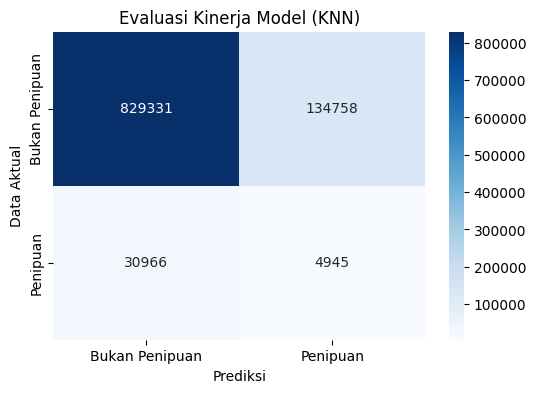

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bukan Penipuan', 'Penipuan'],
            yticklabels=['Bukan Penipuan', 'Penipuan'])
plt.xlabel('Prediksi')
plt.ylabel('Data Aktual')
plt.title('Evaluasi Kinerja Model (KNN)')
plt.show()

In [ ]:
# Evaluasi Kinerja (Classification Report)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nClassification Report Imbalance:")
print(classification_report_imbalanced(y_test, y_pred))

Accuracy Score: 0.8343

Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.86      0.91    964089
        True       0.04      0.14      0.06     35911

    accuracy                           0.83   1000000
   macro avg       0.50      0.50      0.48   1000000
weighted avg       0.93      0.83      0.88   1000000


Classification Report Imbalance:
                   pre       rec       spe        f1       geo       iba       sup

      False       0.96      0.86      0.14      0.91      0.34      0.13    964089
       True       0.04      0.14      0.86      0.06      0.34      0.11     35911

avg / total       0.93      0.83      0.16      0.88      0.34      0.13   1000000



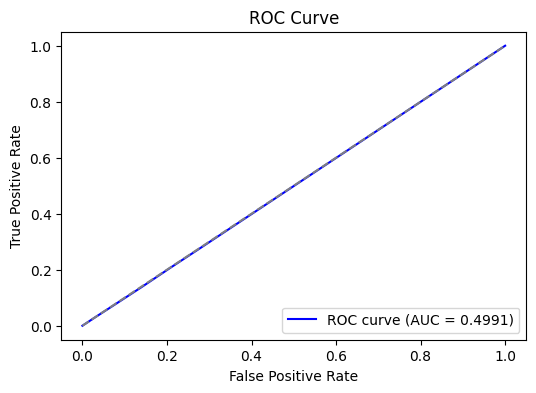

In [ ]:
# Receiver Operating Characteristic Curve (ROC Curve)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()